In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 16 rows, 66 columns and 126 nonzeros
Model fingerprint: 0x07247d7b
Variable types: 0 continuous, 66 integer (66 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e+01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8751470.0000
Presolve time: 0.00s
Presolved: 16 rows, 66 columns, 126 nonzeros
Variable types: 0 continuous, 66 integer (66 binary)
Found heuristic solution: objective 8750905.0000

Root relaxation: objective 4.063665e+06, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

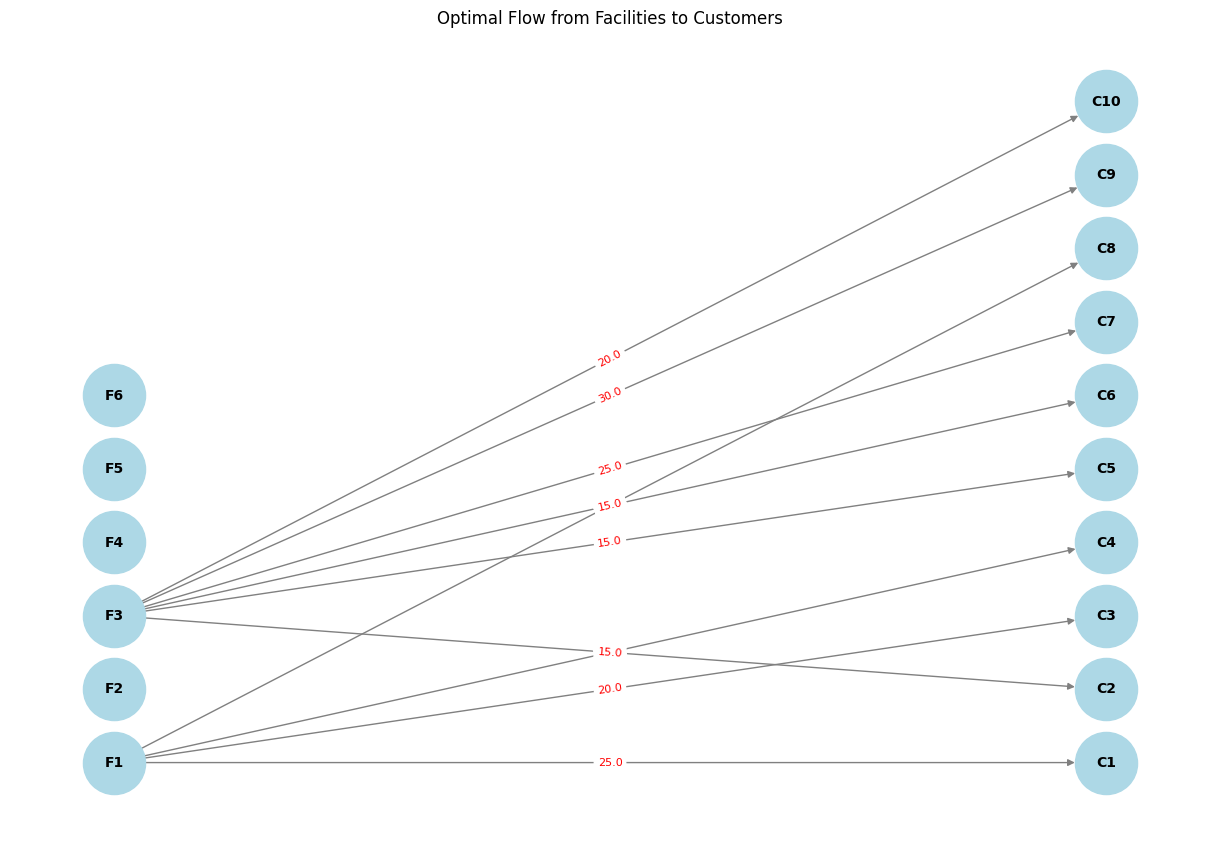

In [2]:

# Define the sets and parameters
num_customers = 10
num_facilities = 6

customers = range(num_customers)
facilities = range(num_facilities)

# Cost of opening each facility
facility_costs = [1.75, 2, 2.5, 2.25, 1.5, 1]

# Capacity of each facility
facility_capacity = [75, 50, 120, 100, 60, 50]

# Demand of each customer
customer_demand = [25, 15, 20, 10, 15, 15, 25, 20, 30, 20]

# Transportation cost from each facility to each customer
transportation_cost = [
    [3, 6, 5, 7, 10, 12, 7, 5, 8, 10],
    [5, 7, 3, 6, 8, 6, 10, 6, 10, 12],
    [8, 10, 8, 7, 5, 4, 6, 9, 7, 8],
    [12, 12, 10, 10, 8, 7, 6, 4, 5, 3],
    [10, 8, 12, 9, 6, 5, 8, 4, 4, 4],
    [11, 10, 10, 5, 5, 4, 3, 7, 6, 6]
]

# Create a Gurobi model
model = gp.Model("CFLP")

# Define decision variables
x = {}  # Binary decision variable indicating if a facility is open
y = {}  # Binary decision variable representing assignment from facility to customer

for i in facilities:
    x[i] = model.addVar(vtype=GRB.BINARY, name=f"x[{i}]")

for i in facilities:
    for j in customers:
        y[i, j] = model.addVar(vtype=GRB.BINARY, name=f"y[{i},{j}]")

# Set objective function: Minimize the total cost
model.setObjective(
    gp.quicksum(facility_costs[i] * 1000000 * x[i] for i in facilities) +
    gp.quicksum(transportation_cost[i][j] * customer_demand[j] * y[i, j] for i in facilities for j in customers),
    GRB.MINIMIZE
)

# Capacity constraints: Flow out of each facility must be less than or equal to its capacity
for i in facilities:
    model.addConstr(
        gp.quicksum(y[i, j] * customer_demand[j] for j in customers) <= facility_capacity[i] * x[i],
        f"Capacity_Constraint[{i}]"
    )

# Demand constraints: Each customer must receive its demand
for j in customers:
    model.addConstr(
        gp.quicksum(y[i, j] for i in facilities) == 1,
        f"Demand_Constraint[{j}]"
    )

# Optimize the model
model.optimize()

# Check if the model found an optimal solution
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    print("Objective Value:", model.objVal)

    # Extract the optimal solution
    open_facilities = [i for i in facilities if x[i].x > 0.5]
    flows = [(i, j, y[i, j].x * customer_demand[j]) for i in facilities for j in customers if y[i, j].x > 0.5]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for facilities and customers
    G.add_nodes_from(f"F{i+1}" for i in facilities)  # Facilities as F1, F2, ...
    G.add_nodes_from(f"C{j+1}" for j in customers)   # Customers as C1, C2, ...

    # Add edges with flow values
    for i, j, flow in flows:
        G.add_edge(f"F{i+1}", f"C{j+1}", weight=flow)

    # Define positions for facilities and customers
    pos = {}
    for i in facilities:
        pos[f"F{i+1}"] = (0, i)
    for j in customers:
        pos[f"C{j+1}"] = (1, j)

    # Draw the network
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

    # Draw edge labels
    edge_labels = {(f"F{i+1}", f"C{j+1}"): f"{flow:.1f}" for i, j, flow in flows}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    plt.title('Optimal Flow from Facilities to Customers')
    plt.show()

else:
    print("No optimal solution found.")
